## Preparation du dataset ##


In [140]:
# Imports
import numpy as np
import pandas as pd
import re
import math as math
# import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import graphlib
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.tools as tls
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import KFold

# Chargement du dataset
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

PassengerId = test['PassengerId']

test.head(3)
# train["Cabin"].value_counts()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [141]:

from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
original_train = train.copy() 
original_test  = test.copy()
# print(original_test)
full_data = [train, test]

train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin']  = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

#SibSp nombre de freres et soeurs/Epouses ; Parch - Number of Parents/Children Aboard;
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

for dataset in full_data:
    #fare = tarif
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# suppression des NULL dans column Age
for dataset in full_data:
    age_mean = dataset['Age'].mean()
    # print(dataset['Age'].describe())
    age_std = dataset['Age'].std() #Ecart Type
    # print(age_std)
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_mean - age_std, age_mean + age_std, size=age_null_count)
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Fonction pour avoir les titre
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # Si le titre Existe le returneeeeeeeee.
    if title_search:
        # print(title_search)
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Grouper tout les titre rare en un seul "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)



#Embarked - Port d'Embarquement (C = Cherbourg; Q = Queenstown; S = Southampton)
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

  
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] =4

In [142]:
#OneHot encoding
oneHot = OneHotEncoder()
d = dataset["Embarked"].values.reshape(-1,1)
# print(d)
oneHot.fit(d)
onelabl = oneHot.transform(d).toarray()
lieu = original_train["Embarked"].fillna("S").unique()
print(lieu)
# print(onelabl)
l = ["EmbarquedS","EmbarquedC","EmbarquedQ"]
l

for i in lieu:
  dataset["Embarqued"+i]=(onelabl[:,lieu.tolist().index(i)]).astype(int)

# dataset




['S' 'C' 'Q']


In [143]:
ti = dataset["Title"].values.reshape(-1,1)
oneHot.fit(ti)
lab = oneHot.transform(ti).toarray()
listTitle = dataset["Title"].unique()
listTitle


array([1, 3, 4, 2, 5], dtype=int64)

In [144]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
# for dataset in full_data:
#     dataset.drop(drop_elements, axis=1)
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

## Visualisation des donnees ##

In [145]:
train.head(3)
# Nos donnees sont beaucoup plus clair et plus lisible

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4


<AxesSubplot:title={'center':'Pearson Correlation des colomn'}>

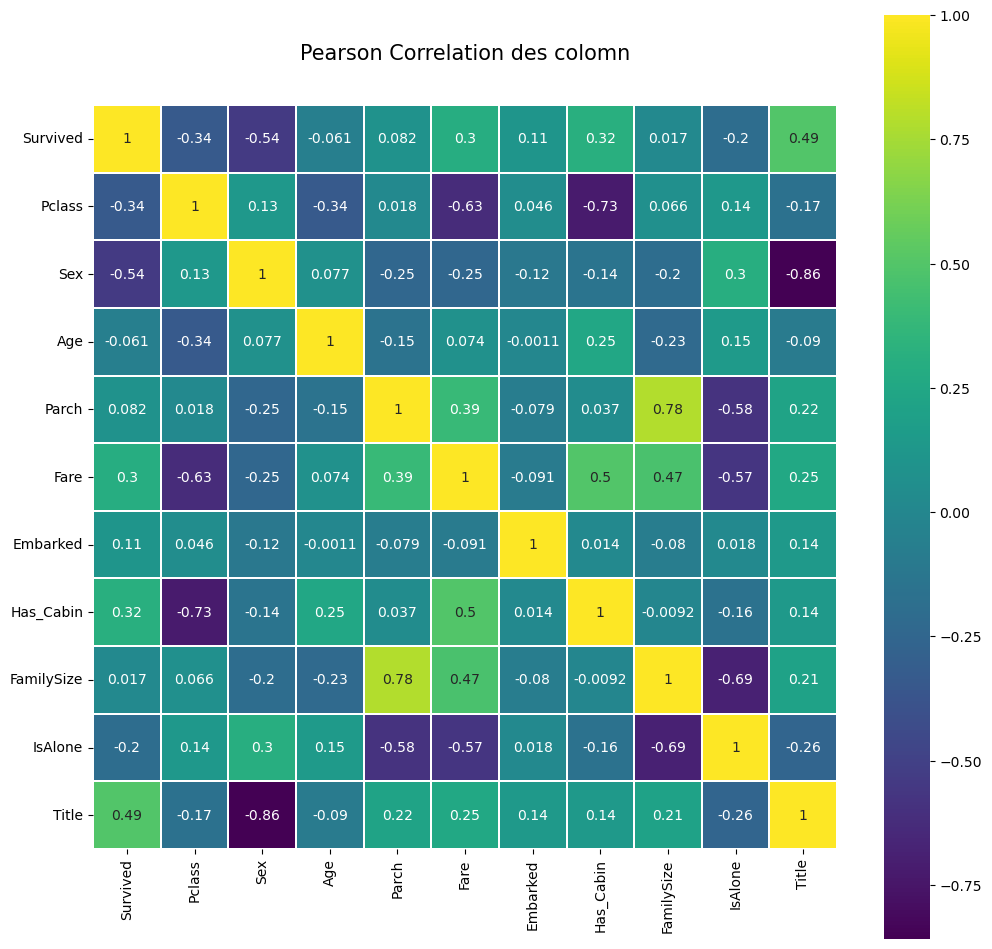

In [146]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation des colomn', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)


In [147]:
train["Sex"].sor

AttributeError: 'Series' object has no attribute 'sor'

*Title* VS *Sex*
-------

In [ ]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])
# title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

Survived           
           mean count  sum
Title                     
1      0.156673   517   81
2      0.575000    40   23
3      0.793651   126  100
4      0.702703   185  130
5      0.347826    23    8

In [ ]:
train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])
    
# sex_mapping = {{'female': 0, 'male': 1}} 

Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

In [ ]:

title_and_sex = original_train.copy()[['Name', 'Sex']]

title_and_sex['Title'] = title_and_sex['Name'].apply(get_title)

title_and_sex['Sex'] = title_and_sex['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

title_and_sex[['Title', 'Sex']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])


Sex           
              mean count  sum
Title                        
Capt      1.000000     1    1
Col       1.000000     2    2
Countess  0.000000     1    0
Don       1.000000     1    1
Dr        0.857143     7    6
Jonkheer  1.000000     1    1
Lady      0.000000     1    0
Major     1.000000     2    2
Master    1.000000    40   40
Miss      0.000000   182    0
Mlle      0.000000     2    0
Mme       0.000000     1    0
Mr        1.000000   517  517
Mrs       0.000000   125    0
Ms        0.000000     1    0
Rev       1.000000     6    6
Sir       1.000000     1    1

## Gini


In [ ]:
#Fonction de calcul du GINI
# def calculGini(nbre_survivant, total_count):
#     survivant_prob = nbre_survivant/total_count
#     non_survivant_prob = (1 - survivant_prob)
#     # random_observation_survived_prob = survival_prob
#     # random_observation_not_survived_prob = (1 - random_observation_survived_prob)
#     # mislabelling_survided_prob = not_survival_prob *random_observation_survived_prob
#     # mislabelling_not_survided_prob = survival_prob *random_observation_not_survived_prob
#    # gini_impurity = mislabelling_survided_prob+ mislabelling_not_survided_prob
#     g = survivant_prob*(1-non_survivant_prob)
#     print(g*2)
#     impirite_gini = survivant_prob*non_survivant_prob*2#+ not_survival_prob*survival_prob
#     return impirite_gini

In [ ]:
# gini_impurity_starting_node = calculGini(342, 891)
# gini_impurity_starting_node

In [ ]:
# gini_impurity_men = calculGini(109, 577)
# gini_impurity_men

In [ ]:
# gini_impurity_women = calculGini(233, 314)
# gini_impurity_women

In [ ]:
# Gini Impurity decroit si noeud divise par Sex
# men_weight = 577/891
# women_weight = 314/891
# weighted_gini_impurity_sex_split = (gini_impurity_men * men_weight) + (gini_impurity_women * women_weight)

# sex_gini_decrease = weighted_gini_impurity_sex_split - gini_impurity_starting_node
# sex_gini_decrease

In [ ]:
# gini_impurity_title_1 = calculGini(81, 517)
# gini_impurity_title_1

In [ ]:
# # Gini Impurity decrease if node splited for observations with Title != 1 != Mr
# gini_impurity_title_others = calculGini(261, 374)
# gini_impurity_title_others

In [ ]:
# # Gini Impurity decrease if node splited for observations with Title == 1 == Mr
# title_1_weight = 517/891
# title_others_weight = 374/891
# weighted_gini_impurity_title_split = (gini_impurity_title_1 * title_1_weight) + (gini_impurity_title_others * title_others_weight)

# title_gini_decrease = weighted_gini_impurity_title_split - gini_impurity_starting_node
# title_gini_decrease

In [ ]:
#Recherche de la profondeur optimale en fonction des Accurency de differentes profondeurs
cv = KFold(n_splits=10)  
accuracies = list()
max_attributes = len(list(train))
depth_range = range(1, max_attributes + 1)
# print(cv.split(train))
# Test des max_depths de 1  var max_attributes
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    #Divise train en 10 parts, utilise une part comme donneeValidation, les autres comme donneeTrain
    for trainData, validationData in cv.split(train):
        # print(valid_fold)
        f_train = train.loc[trainData] # Extraction des donnees d'entrainemnt avec indices cv

        f_valid = train.loc[validationData] # Extraction des donnees de validation avec indices cv

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # Entrainement avec les donnees d'entrainement
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])# Calcul de l'Accurency avec les donnees de validation
        fold_accuracy.append(valid_acc)

    average = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(average)
    
    

df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.782285
         2          0.799189
         3          0.828277
         4          0.819288
         5          0.819313
         6          0.808140
         7          0.809213
         8          0.811486
         9          0.819338
        10          0.818202
        11          0.812609


## Arbre Final ##

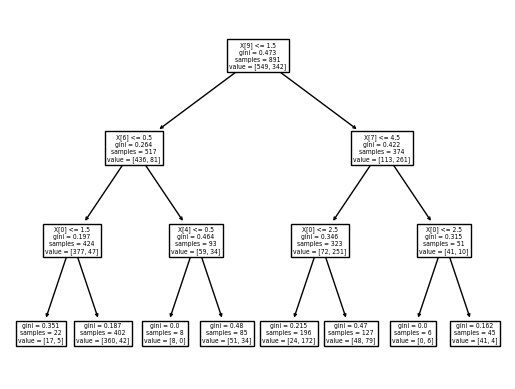

In [ ]:
# Creation des tableaux NumPy  des donnee train
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1).values 
x_test = test.values

# Creation de l'arbre avec profondeur = 3
arbre = tree.DecisionTreeClassifier(criterion="gini", max_depth=3)
arbre.fit(x_train, y_train)
tree.plot_tree(arbre, )
# Prediction des resultat pour nos donnees de test
y_pred = arbre.predict(x_test, )
df_fichier = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": y_pred
    })
df_fichier.to_csv('resultat_model.csv', index=False)

# list(train.drop(["Survived"], axis=1))




In [ ]:
precision_arbre = round(arbre.score(x_train, y_train) * 100, 2)
print(precision_arbre)
# metrics.precision_recall_fscore_support(test["Age"], y_pred)
# metrics.accuracy_score(test["Age"].values, y_pred)
f1Score = metrics.f1_score(test["Age"], y_pred, average="macro")
recallScore= metrics.recall_score(test["Age"], y_pred, average="macro")
matrice_c=metrics.multilabel_confusion_matrix(test["Age"], y_pred)
tn = matrice_c[:, 0, 0]
tp = matrice_c[:, 1, 1]
fn = matrice_c[:, 1, 0]
fp = matrice_c[:, 0, 1]
sensitivity = tp/(fn+tp)
specificity = tn/(fp+tn)
print(matrice_c)



82.38
[[[142 240]
  [ 26  10]]

 [[101  84]
  [149  84]]

 [[308   0]
  [110   0]]

 [[381   0]
  [ 37   0]]

 [[416   0]
  [  2   0]]]


# Regression

54.72

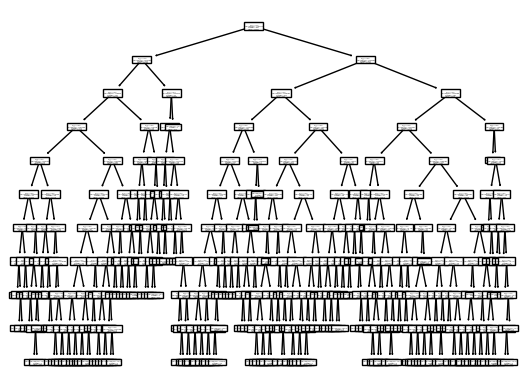

In [ ]:

dfo = [train.copy(), test.copy()]
dfo[0]["Age"]=  original_train["Age"]
dfo[1]["Age"] = original_test["Age"]
x_trainr=dfo[0].drop(["Age"], axis=1).values

for dataset in dfo:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std() #Ecart Type
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

y_trainr= dfo[0].Age.values
y_trainr
reg = tree.DecisionTreeRegressor(max_depth=10)
modell = reg.fit(x_trainr,y_trainr)
x_testr = dfo[1].values

y_predic_r = modell.predict(x_testr)
y_predic_r
df_fichier_r = pd.DataFrame({
        "PassengerId": PassengerId,
        "Age": y_predic_r
    })
df_fichier_r.to_csv('resultat_model_r.csv', index=False)
df_fichier_r
tree.plot_tree(modell)
arbre_precision_r = round(modell.score(x_trainr, y_trainr )*100,2)
arbre_precision_r